## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import re
import urllib.request
api_url = 'https://raw.githubusercontent.com/tanmayyb/ele70_bv03/refs/heads/main/api/datasets.py'
exec(urllib.request.urlopen(api_url).read())

## Load Datasets and Preprocess

In [2]:
load_offline = True

In [3]:
if not load_offline:
  ieso_dataset = load_ieso_dataset(2010, 2020, join=True).iloc[:-1]
  ieso_dataset.to_csv('./data/ieso_dataset.csv', index=False)
else:
  ieso_dataset = pd.read_csv('./data/ieso_dataset.csv')
  ieso_dataset.DateTime = pd.to_datetime(ieso_dataset.DateTime)

In [4]:
if not load_offline:
  weather_dataset = load_climate_dataset(2010, 2020, join=True).iloc[1:]
  weather_dataset.to_csv('./data/weather_dataset.csv', index=False)
else:
  weather_dataset = pd.read_csv('./data/weather_dataset.csv')
  weather_dataset.DateTime = pd.to_datetime(weather_dataset.DateTime)

C:\Users\tanma\AppData\Local\Temp\ipykernel_16668\598990861.py:5: DtypeWarning: Columns (10,12,14,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_dataset = pd.read_csv('./data/weather_dataset.csv')


In [5]:
#@markdown merge and preprocess

dataset = pd.merge(ieso_dataset, weather_dataset, on="DateTime")

def preprocess(dataset:pd.DataFrame, split_datetime=True) -> pd.DataFrame:
  df = dataset.copy()
  ieso_cols = ['Toronto']
  climate_cols = [
       'Temp (°C)',
      #  'Temp Flag',
       'Dew Point Temp (°C)',
      #  'Dew Point Temp Flag',
       'Rel Hum (%)',
      #  'Rel Hum Flag',
       'Precip. Amount (mm)',
      #  'Precip. Amount Flag',
      #  'Wind Dir (10s deg)',
      #  'Wind Dir Flag',
      #  'Wind Spd (km/h)',
      #  'Wind Spd Flag',
      #  'Visibility (km)',
      #  'Visibility Flag',
       'Stn Press (kPa)',
      #  'Stn Press Flag',
       'Hmdx',
      #  'Hmdx Flag', 'Wind Chill', 'Wind Chill Flag', 'Weather'
      ]
  if split_datetime:
    df['Y'] = df['DateTime'].dt.year
    df['M'] = df['DateTime'].dt.month
    df['D'] = df['DateTime'].dt.day
    df['H'] = df['DateTime'].dt.hour
    cols = ['Y', 'M', 'D', 'H']
  else:
    cols = ['DateTime']

  # delete leap day
  df = df[~((df.DateTime.dt.month == 2) & (df.DateTime.dt.day == 29))]
  dt = df['DateTime'] # store datettime

  cols += ieso_cols+climate_cols

  df = df[cols]

  # make columns names better
  df.columns = df.columns.str.replace('.', '')
  df.columns = df.columns.str.replace(' ', '')
  df.columns = df.columns.str.replace(r"\(.*?\)", "", regex=True)

  nans = df.isna().sum().to_dict()

  # dirty mean imputation
  data = df.fillna(df.mean())

  # # dirty -1 imputation
  # data = df.fillna(pd.Series(index=df.columns, data=[-1.0]*len(df.columns)))

  data = data.reset_index()

  return df, nans, dt

df, nans, dt = preprocess(dataset)

```
RelHum -> 0-100 norm
Hmdx-> 0-100 norm
Toronto -> mean norm
Temp -> mean norm
DewPointTemp -> mean norm
PrecipAmount -> mean norm
StnPress -> mean norm
```

In [6]:
df

,Y,M,D,H,Toronto,Temp,DewPointTemp,RelHum,PrecipAmount,StnPress,Hmdx
0,2010,1,1,1,4966,2.4,1.7,95.0,NaN,NaN,NaN
1,2010,1,1,2,4761,2.1,1.4,95.0,NaN,NaN,NaN
2,2010,1,1,3,4594,2.0,1.4,96.0,NaN,NaN,NaN
3,2010,1,1,4,4443,1.7,1.2,96.0,NaN,NaN,NaN
4,2010,1,1,5,4375,1.5,1.1,97.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96426,2020,12,31,19,6123,1.9,-3.8,66.0,0.0,100.98,NaN
96427,2020,12,31,20,5948,2.0,-3.8,65.0,0.0,101.06,NaN
96428,2020,12,31,21,5741,2.2,-3.7,65.0,0.0,101.13,NaN
96429,2020,12,31,22,5527,2.1,-3.9,65.0,0.0,101.23,NaN


In [20]:
def create_train_test_split(dataset:pd.DataFrame, target:str='target', split_coeff:float=0.8, dt=None) -> tuple:
  training_cutoff = int(split_coeff*len(dataset))
  train = dataset.iloc[:training_cutoff]
  test = dataset.iloc[training_cutoff:]

  X_train = train.drop(columns=[target])
  y_train = train[target]
  X_test = test.drop(columns=[target])
  y_test = test[target]

  (train_idx, test_idx) = None, None
  if dt is not None:
    train_idx = dt[:training_cutoff]
    test_idx = dt[training_cutoff:]

  return (X_train, X_test, y_train, y_test), (train_idx, test_idx)

target = 'Toronto'
(X_train, X_test, y_train, y_test), (train_idx, test_idx) = create_train_test_split(df, target=target, dt=dt)
y_test_numpy = y_test.to_numpy()

## Visualize XGBoost Learning

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

<Figure size 2000x1000 with 0 Axes>

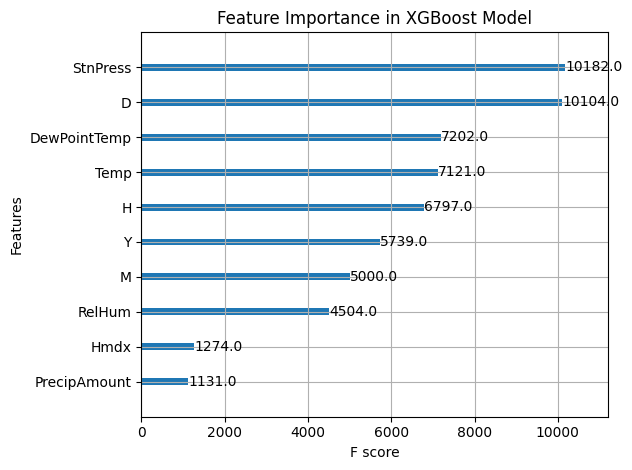

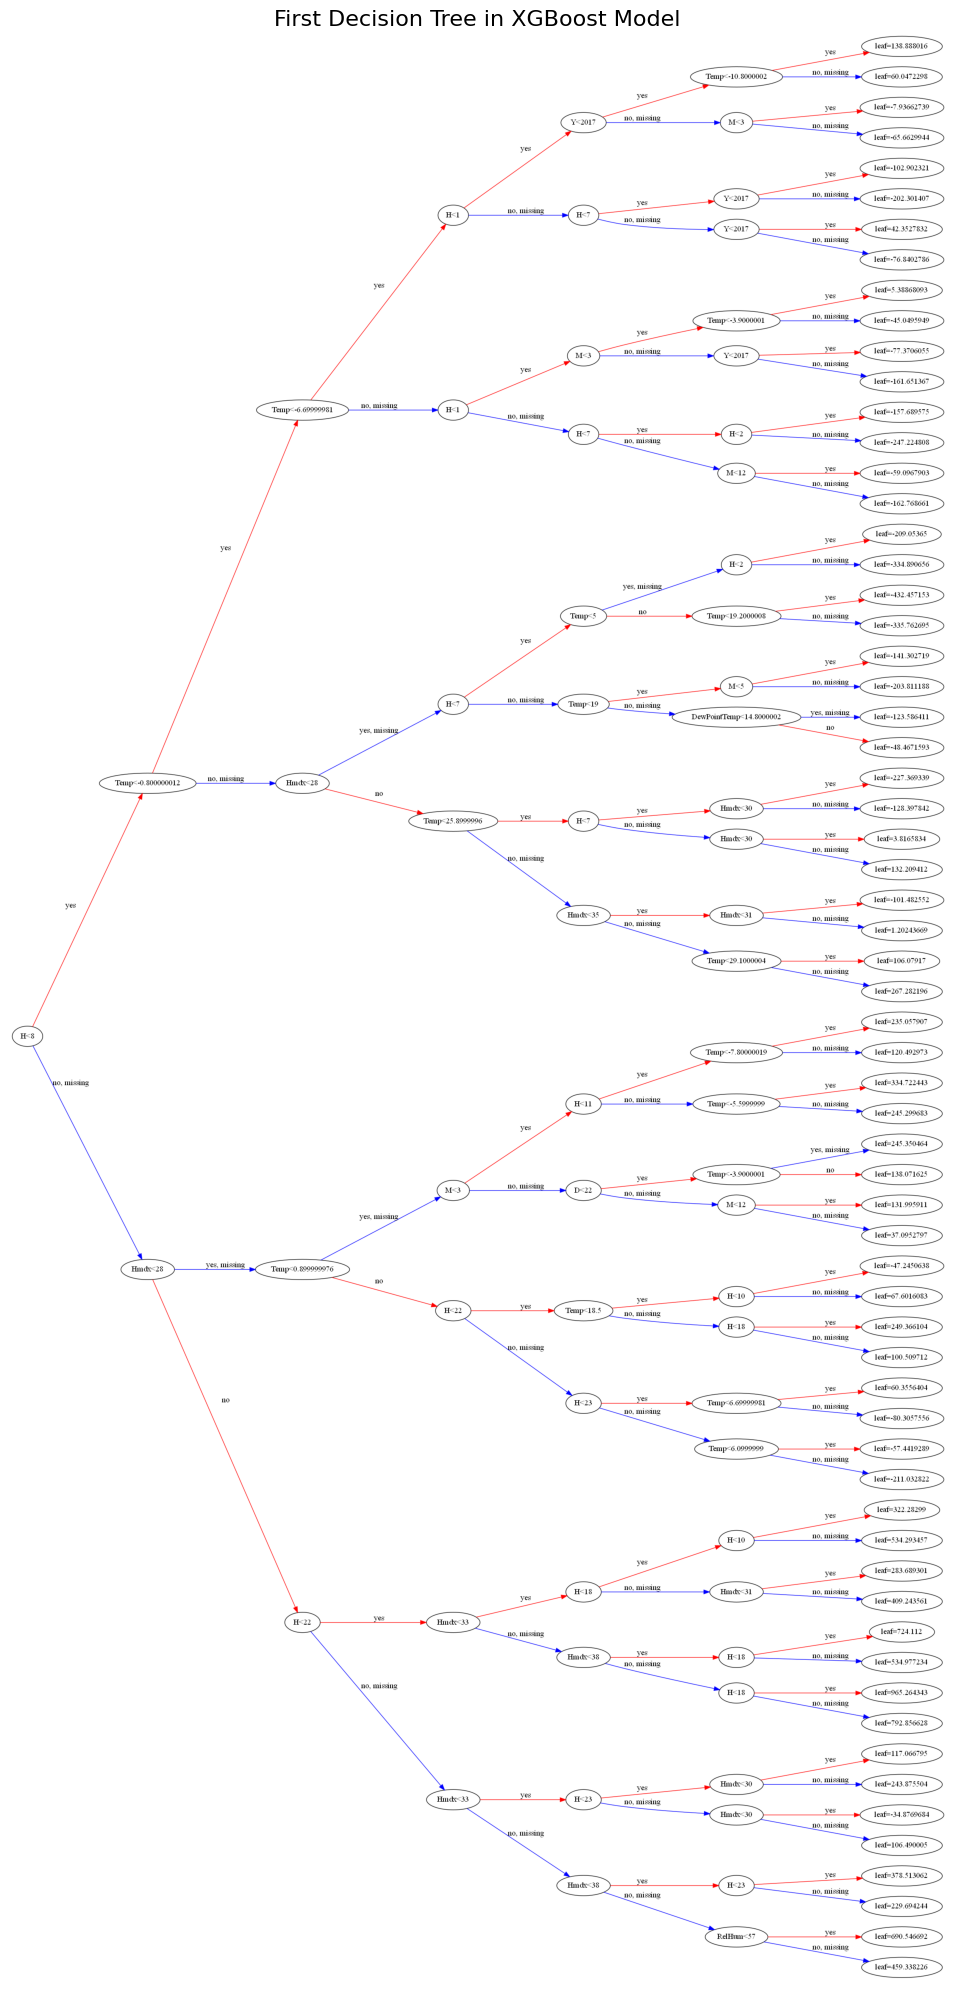

In [21]:
# Load the saved model
model = xgb.Booster()
model.load_model('./outputs/xgb_mt1r1_model.json')

# Create a figure with larger size
plt.figure(figsize=(20,10))

# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

# Plot the tree with better visibility
plt.figure(figsize=(30, 20))  # More balanced aspect ratio
xgb.plot_tree(model, 
              num_trees=0,
              rankdir='LR',    # Left to right layout
              ax=plt.gca()     # Get current axis
              )
plt.title('First Decision Tree in XGBoost Model', fontsize=16)
plt.tight_layout()
plt.savefig('./outputs/xgb_mt1r1_trees.png', dpi=300, bbox_inches='tight')
plt.show()

## XGBoost Regression Model - Grid Search

In [9]:
# https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Create-XGBoost-Model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        # early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
pred = reg.predict(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

# Define parameter grid with reduced search space
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# Create base model
xgb_model = xgb.XGBRegressor()

# Calculate total number of combinations
n_combinations = (len(param_grid['max_depth']) * 
                 len(param_grid['learning_rate']) * 
                 len(param_grid['n_estimators']) * 
                 len(param_grid['min_child_weight']) * 
                 len(param_grid['subsample']) * 
                 len(param_grid['colsample_bytree']) * 
                 len(param_grid['gamma']))

print(f"Total parameter combinations to try: {n_combinations}")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,  # Add some verbosity to see progress
    n_jobs=2    # Reduce number of parallel jobs to avoid overwhelming CPU
)

# Fit with progress update
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# Use best model for predictions
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

Total parameter combinations to try: 128
Starting grid search...
Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 500, 1000, 1500],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Create base model
xgb_model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

# Use best model for predictions
best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


KeyboardInterrupt: 

## Results and Analysis

In [11]:
#@markdown plot prediction
from plotly import graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scattergl(
    x=test_idx,
    y=y_test.to_numpy(),
    name='Actual',
    line_color='blue')
)

fig.add_trace(go.Scattergl(
    x=test_idx,
    y=pred,
    name='Predicted',
    line_color='red')
)


# Set the theme to 'plotly_white'
fig.update_layout(
    title=f"Time Series Forecasting for {target} with XGBoostRegressor",
    xaxis_title="t (1 unit = 1 hour)",
    yaxis_title="Energy Demand",
    template="plotly_white",
    xaxis = dict( rangeslider=dict(
      visible=True
    ))
)
fig.show()
# fig.write_html(f'mcr4_xgb_mt1r1_pred.html')

In [12]:
#@markdown calculate MSE, MAE, MAPE
mse = mean_squared_error(y_true=y_test,
                   y_pred=pred)

mae = mean_absolute_error(y_true=y_test,
                   y_pred=pred)

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, pred)}")

MSE: 217445.296875
MAE: 357.2857971191406
MAPE: 6.467342163658422


In [13]:
#@markdown top 10 worst predictions
tmp = pd.concat([dt, y_test, pd.Series(pred, index=y_test.index, name='pred')],
                axis=1).dropna()

tmp['error'] = tmp[target] - tmp['pred']
tmp['abs_error'] = tmp['error'].apply(np.abs)

worst_predicted = tmp.sort_values(by='abs_error', ascending=False)
worst_predicted[:10]

,DateTime,Toronto,pred,error,abs_error
92202,2020-07-08 19:00:00,9000.0,6343.770020,2656.229980,2656.229980
90056,2020-04-10 09:00:00,4522.0,6628.996582,-2106.996582,2106.996582
90055,2020-04-10 08:00:00,4379.0,6481.874023,-2102.874023,2102.874023
93801,2020-09-13 10:00:00,5141.0,7233.699219,-2092.699219,2092.699219
93802,2020-09-13 11:00:00,5399.0,7462.314453,-2063.314453,2063.314453
91263,2020-05-30 16:00:00,4875.0,6895.419434,-2020.419434,2020.419434
90057,2020-04-10 10:00:00,4613.0,6586.463379,-1973.463379,1973.463379
93809,2020-09-13 18:00:00,5752.0,7699.018555,-1947.018555,1947.018555
93808,2020-09-13 17:00:00,5817.0,7747.412598,-1930.412598,1930.412598
93657,2020-09-07 10:00:00,5012.0,6898.599121,-1886.599121,1886.599121


In [14]:
#@markdown top 10 best predictions
best_predicted = tmp.sort_values(by='abs_error', ascending=True)
best_predicted[:10]

,DateTime,Toronto,pred,error,abs_error
96186,2020-12-21 19:00:00,6643.0,6643.044922,-0.044922,0.044922
77431,2018-11-01 08:00:00,5835.0,5834.920898,0.079102,0.079102
84910,2019-09-08 23:00:00,4496.0,4496.089844,-0.089844,0.089844
86672,2019-11-21 09:00:00,6105.0,6105.141113,-0.141113,0.141113
92354,2020-07-15 03:00:00,4881.0,4881.197754,-0.197754,0.197754
87050,2019-12-07 03:00:00,4852.0,4852.218262,-0.218262,0.218262
84429,2019-08-19 22:00:00,6568.0,6567.772461,0.227539,0.227539
89232,2020-03-07 01:00:00,5087.0,5086.763184,0.236816,0.236816
79964,2019-02-14 21:00:00,6621.0,6620.723633,0.276367,0.276367
95832,2020-12-07 01:00:00,4965.0,4965.280762,-0.280762,0.280762


In [15]:
best_predicted.iloc[:168].sort_index()

,DateTime,Toronto,pred,error,abs_error
77267,2018-10-25 12:00:00,5934.0,5935.841797,-1.841797,1.841797
77273,2018-10-25 18:00:00,6201.0,6202.523926,-1.523926,1.523926
77431,2018-11-01 08:00:00,5835.0,5834.920898,0.079102,0.079102
77437,2018-11-01 14:00:00,6052.0,6053.271973,-1.271973,1.271973
77459,2018-11-02 12:00:00,6145.0,6148.050293,-3.050293,3.050293
...,...,...,...,...,...
95868,2020-12-08 13:00:00,6358.0,6356.591309,1.408691,1.408691
95891,2020-12-09 12:00:00,6595.0,6592.875000,2.125000,2.125000
96178,2020-12-21 11:00:00,6229.0,6225.574219,3.425781,3.425781
96186,2020-12-21 19:00:00,6643.0,6643.044922,-0.044922,0.044922


In [24]:
#@markdown plot best/worst predictions
from plotly.subplots import make_subplots

hours = 168*10 # hours in a week
sorted_best_predicted = best_predicted.iloc[:hours].sort_index()
sorted_worst_predicted = worst_predicted.iloc[:hours].sort_index()


fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=(f'Best Predicted Hours for {target}',f'Worst Predicted Hours for {target}'))

# best predicted
fig.append_trace(go.Scattergl(
    x=sorted_best_predicted.DateTime,
    y=sorted_best_predicted[target],
    name='Target',
    mode='markers',
    # line_color='blue'
), row=1, col=1)

fig.append_trace(go.Scattergl(
    x=sorted_best_predicted.DateTime,
    y=sorted_best_predicted[target],
    name='Predicted',
    line_color='red'
), row=1, col=1)


# worst predicted
fig.append_trace(go.Scattergl(
    x=sorted_worst_predicted.DateTime,
    y=sorted_worst_predicted[target],
    name='Target',
    mode='markers',
    # line_color='blue'
), row=2, col=1)

fig.append_trace(go.Scattergl(
    x=sorted_worst_predicted.DateTime,
    y=sorted_worst_predicted.pred,
    name='Predicted',
    line_color='red'
), row=2, col=1)


fig.update_layout(
    title=f"Best/Worst Predictions for: {target}",

    # yaxis_title="Energy Demand",
    template="plotly_white",
)

fig.update_xaxes(
    title="t (1 unit = 1 hour)",
    rangeslider_visible=True, row=2, col=1)


# https://stackoverflow.com/questions/77370313/plotting-subplots-with-a-shared-slider-in-python
fig.show()
fig.write_html(f'./outputs/xgb_mt1r1_pred_eval.html')


## Wrapping Up

In [23]:
# save as csv for anomaly detection
tmp.to_csv('./outputs/xgb_mt1r1_pred_eval.csv')

In [22]:
# save learned model
reg.save_model('./outputs/xgb_mt1r1_model.json')  # Save model in JSON format

In [18]:
#@markdown wandb code for later

# !pip install wandb
# wandb login

# wandb.init(
#     # set the wandb project where this run will be logged
#     project="my-awesome-project",

#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 0.02,
#     "architecture": "CNN",
#     "dataset": "CIFAR-100",
#     "epochs": 10,
#     }
# )

# # simulate training
# epochs = 10
# offset = random.random() / 5
# for epoch in range(2, epochs):
#     acc = 1 - 2 ** -epoch - random.random() / epoch - offset
#     loss = 2 ** -epoch + random.random() / epoch + offset

#     # log metrics to wandb
#     wandb.log({"acc": acc, "loss": loss})

# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()